In [23]:
import os
os.chdir('..')
print(os.getcwd())

/Users/alex.shtoff/git


In [159]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from exp_prox.np import prox_op

In [127]:
def generate_data(m, n):
    # for reproducibility - random seed
    np.random.seed(2024)

    # define function parameters - use long-tailed distributions to get both small and large values
    thetas = np.random.standard_cauchy(size=(m, n))
    phis = np.random.standard_cauchy(size=(m, n))
    bs = np.random.standard_cauchy(size=m)
    alphas = np.random.lognormal(size=m, mean=-3, sigma=2)

    # define prox operator argument and step-sizes
    ws = np.random.standard_cauchy(size=(m, n))
    etas = np.random.lognormal(size=m, mean=-3, sigma=2)

    return ws, etas, thetas, phis, bs, alphas

In [146]:
m = 1000
n = 50
ws, etas, thetas, phis, bs, alphas = generate_data(m, n)

In [147]:
percentiles = [
    np.percentile(z.ravel(), q=[0.1, 1, 25, 50, 75, 99, 99.9])
    for z in [ws, etas, thetas, phis, bs, alphas]
]
percentile_df = pd.DataFrame(percentiles,
             columns=pd.Index(['P-0.1%', 'P-1%', 'P-25%', 'P-50%', 'P-75%', 'P-99%', 'P-99.9%'], name='Percentile'),
             index=pd.Index(['$\\vw$', '$\\eta$', '$\\vtheta$', '$\\vphi$', '$b$', '$\\alpha$'], name='Vector'))
print(percentile_df.to_latex(float_format="%.4g"))

\begin{tabular}{lrrrrrrr}
\toprule
Percentile & P-0.1% & P-1% & P-25% & P-50% & P-75% & P-99% & P-99.9% \\
Vector &  &  &  &  &  &  &  \\
\midrule
$\vw$ & -291.7 & -32.65 & -1.028 & -0.01609 & 0.9835 & 30.84 & 300.9 \\
$\eta$ & 0.0001667 & 0.0006065 & 0.01123 & 0.04689 & 0.1767 & 4.557 & 16.01 \\
$\vtheta$ & -351.7 & -33.79 & -1.022 & -0.00675 & 0.9927 & 30.76 & 389.6 \\
$\vphi$ & -324 & -32.24 & -0.991 & -0.0007571 & 1.009 & 33.37 & 325.2 \\
$b$ & -413.2 & -27.04 & -1.083 & -0.003717 & 1.01 & 32.98 & 292.9 \\
$\alpha$ & 9.546e-05 & 0.0005493 & 0.01294 & 0.04683 & 0.2206 & 5.603 & 40.97 \\
\bottomrule
\end{tabular}



In [148]:
# compute using CVXPY
w_next_cp = []
for row in range(m):
    u = cp.Variable(n)
    objective = (
        cp.exp(cp.vdot(u, thetas[row]) + bs[row]) +
        cp.vdot(u, phis[row]) +
        alphas[row] * cp.sum_squares(u) / 2 +
        cp.sum_squares(ws[row] - u) / (2 * etas[row])
    )
    prob = cp.Problem(cp.Minimize(objective))
    prob.solve()
    w_next_cp.append(u.value)
w_next_cp = np.stack(w_next_cp)

In [153]:
w_next = prox_op(ws, etas, thetas, phis, bs, alphas)

In [154]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.style.use('grayscale')
plt.rcParams.update({'font.size': 24, 'axes.labelsize': 24, 'xtick.labelsize': 18})

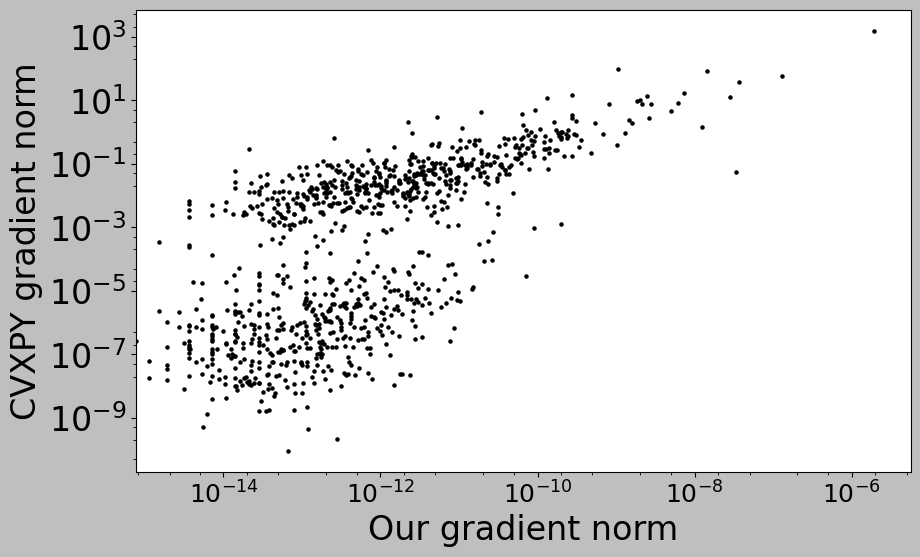

In [170]:
def grad_norms(w_next, ws, etas, thetas, phis, bs, alphas):
    alphas_loc = alphas.reshape(-1, 1)
    etas_loc = etas.reshape(-1, 1)

    exp_arg = np.sum(thetas * w_next, axis=1) + bs
    exp_part = np.exp(exp_arg).reshape(-1, 1)

    grad = thetas * exp_part + phis + alphas_loc * w_next + (w_next - ws) / etas_loc
    return np.max(np.abs(grad), axis=1)

nrm_func = lambda w: grad_norms(w, ws, etas, thetas, phis, bs, alphas)
plt.figure(figsize=(10, 6))
plt.scatter(nrm_func(w_next), nrm_func(w_next_cp), s=5)
plt.xscale('asinh', linear_width=1e-15)
plt.yscale('asinh', linear_width=1e-15)
plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=7))
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=7))
plt.xlabel('Our gradient norm')
plt.ylabel('CVXPY gradient norm')
plt.show()

In [33]:
dims = [10, 20, 50, 100, 500, 1000, 10000, 100000]
mean_norms = []
high_pctile_norms = []
max_norms = []
for dim in dims:
    ws, etas, thetas, phis, bs, alphas = generate_data(m, dim)
    w_next = prox_op(ws, etas, thetas, phis, bs, alphas)
    norms = grad_norms(w_next, ws, etas, thetas, phis, bs, alphas)
    mean_norms.append(np.mean(norms))
    high_pctile_norms.append(np.percentile(norms, q=95))
    max_norms.append(np.max(norms))

In [34]:
import pandas as pd
norms_df = pd.DataFrame({
    'Dimension': dims,
    'Avg. norm': mean_norms,
    'P95 norm': high_pctile_norms,
    'Max. norm': max_norms
})
norms_df

,Dimension,Avg. norm,P95 norm,Max. norm
0,10,1.272746e-11,1.069989e-12,9.775249e-09
1,20,2.758731e-10,2.699120e-12,1.729478e-07
2,50,1.843447e-10,7.552092e-12,1.587323e-07
3,100,2.429381e-10,1.824478e-11,8.520542e-08
4,500,9.825134e-10,1.578096e-10,8.041316e-07
5,1000,1.512684e-09,2.470002e-10,1.104818e-06
6,10000,8.326864e-08,7.897207e-09,4.988358e-05
7,100000,4.389351e-07,1.195001e-07,1.628486e-04


In [39]:
print(norms_df.to_latex(index=False, float_format="%.2e"))

\begin{tabular}{rrrr}
\toprule
Dimension & Avg. norm & P95 norm & Max. norm \\
\midrule
10 & 1.27e-11 & 1.07e-12 & 9.78e-09 \\
20 & 2.76e-10 & 2.70e-12 & 1.73e-07 \\
50 & 1.84e-10 & 7.55e-12 & 1.59e-07 \\
100 & 2.43e-10 & 1.82e-11 & 8.52e-08 \\
500 & 9.83e-10 & 1.58e-10 & 8.04e-07 \\
1000 & 1.51e-09 & 2.47e-10 & 1.10e-06 \\
10000 & 8.33e-08 & 7.90e-09 & 4.99e-05 \\
100000 & 4.39e-07 & 1.20e-07 & 1.63e-04 \\
\bottomrule
\end{tabular}

